# Appliance Energy Dataset

URL: https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction

## Content

1) [Data exploration & preprocessing](#dataproc)

2) [Model training](#train)
    
2.a) [Linear regression](#linear)

2.b) [Lasso Regression](#lasso)

2.c) [Random Forest](#rf)

2.d) [kNN](#knn)

3) Evaluation

---

<a id='dataproc'></a>

# 1) Data exploration & preprocessing

data.describe()



In [4]:
# Basic imports
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display



# models for linear regression
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

# models for Lasso regression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Imports for RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# statistic tools
from sklearn import metrics
from statistics import stdev

# data processing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

---

In [5]:
input_file = 'energydata_complete.csv'
df_raw = pd.read_csv(input_file,  sep = ',', header = 0)
df_raw

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,...,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,...,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,...,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,...,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,...,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,...,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,...,23.200000,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784


In [6]:
display(df_raw.info())

print('Number of rows:' , df_raw.shape[0])
print('Number of columns in dataset is:' , df_raw.shape[1])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

None

Number of rows: 19735
Number of columns in dataset is: 29


Some notes to take from this:
- quite high dimensional
- absolutely no missing values as far as pandas can tell...there might still be faulty, abnormally or otherwise problematic values
- essentially all values are numerical
- only the date column needs to be converted to datetime

In [7]:
df_raw['date'] = pd.to_datetime(df_raw['date'])
display(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         19735 non-null  datetime64[ns]
 1   Appliances   19735 non-null  int64         
 2   lights       19735 non-null  int64         
 3   T1           19735 non-null  float64       
 4   RH_1         19735 non-null  float64       
 5   T2           19735 non-null  float64       
 6   RH_2         19735 non-null  float64       
 7   T3           19735 non-null  float64       
 8   RH_3         19735 non-null  float64       
 9   T4           19735 non-null  float64       
 10  RH_4         19735 non-null  float64       
 11  T5           19735 non-null  float64       
 12  RH_5         19735 non-null  float64       
 13  T6           19735 non-null  float64       
 14  RH_6         19735 non-null  float64       
 15  T7           19735 non-null  float64       
 16  RH_7

None

In [8]:
df_raw.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,...,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,...,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,...,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,...,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,...,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,...,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


# Description of data columns

date time year-month-day hour:minute:second

Appliances, energy use in Wh

lights, energy use of light fixtures in the house in Wh

T1, Temperature in kitchen area, in Celsius

RH_1, Humidity in kitchen area, in %

T2, Temperature in living room area, in Celsius

RH_2, Humidity in living room area, in %

T3, Temperature in laundry room area

RH_3, Humidity in laundry room area, in %

T4, Temperature in office room, in Celsius

RH_4, Humidity in office room, in %

T5, Temperature in bathroom, in Celsius

RH_5, Humidity in bathroom, in %

T6, Temperature outside the building (north side), in Celsius

RH_6, Humidity outside the building (north side), in %

T7, Temperature in ironing room , in Celsius

RH_7, Humidity in ironing room, in %

T8, Temperature in teenager room 2, in Celsius

RH_8, Humidity in teenager room 2, in %

T9, Temperature in parents room, in Celsius

RH_9, Humidity in parents room, in %

To, Temperature outside (from Chievres weather station), in Celsius

Pressure (from Chievres weather station), in mm Hg

RH_out, Humidity outside (from Chievres weather station), in %

Wind speed (from Chievres weather station), in m/s

Visibility (from Chievres weather station), in km

Tdewpoint (from Chievres weather station), Â°C

rv1, Random variable 1, nondimensional

rv2, Random variable 2, nondimensional 

In [9]:
col_dict = {
    'date': 'time year-month-day hour:minute:second',
    'Appliances': 'energy use in Wh',
    'lights':' energy use of light fixtures in the house in Wh',
    'T1': 'Temperature in kitchen area: in Celsius',
    'RH_1':' Humidity in kitchen area: in %',
    'T2': 'Temperature in living room area: in Celsius',
    'RH_2':' Humidity in living room area: in %',
    'T3': 'Temperature in laundry room area',
    'RH_3': 'Humidity in laundry room area: in %',
    'T4': 'Temperature in office room: in Celsius',
    'RH_4': 'Humidity in office room: in %',
    'T5': 'Temperature in bathroom in Celsius',
    'RH_5': 'Humidity in bathroom in %',
    'T6': 'Temperature outside the building (north side: in Celsius',
    'RH_6': 'Humidity outside the building (north side): in %',
    'T7': 'Temperature in ironing room: in Celsius',
    'RH_7': 'Humidity in ironing room in %',
    'T8': 'Temperature in teenager room 2 in Celsius',
    'RH_8':' Humidity in teenager room 2 in %',
    'T9': 'Temperature in parents room in Celsius',
    'RH_9': 'Humidity in parents room: in %',
    'T_out': 'Temperature outside (from Chievres weather station): in Celsius',
    'Press_mm_hg': 'from Chievres weather station) in mm Hg',
    'RH_out': 'Humidity outside (from Chievres weather station): in %',
    'Windspeed': '(from Chievres weather station) in m/s',
    'Visibility': '(from Chievres weather station) in km',
    'Tdewpoint': '(from Chievres weather station) °C',
    'rv1': 'Random variable 1: nondimensional',
    'rv2': 'Random variable 2: nondimensional',
    "threshh": 'gives quartill of Appliance energy usage (0...<25%, 1...<50%, 2...<75%, 3...>75%)'
}

# Divide amongst type of columns --> usefull for visualizations later
col_target = "Appliances"
col_light = "lights"
col_temp = ['T'+str(i) for i in range(1,10)]
col_hum = ['RH_'+str(i) for i in range(1,10)]
col_weather = ["T_out", "Tdewpoint","RH_out","Press_mm_hg","Windspeed","Visibility"] 
col_randoms = ["rv1", "rv2"]
col_vars = col_temp + col_hum + col_weather + [col_light] + ["threshh"]

In [10]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)
            
def add_RD(df):
    df['RD'] = df.apply(lambda row: row.RS - row.RA, axis = 1) 

In [11]:
display_all(df_raw.tail().transpose())
print('#'*40)
display('Some more info')
print('#'*40)
display(df_raw.info())

,19730,19731,19732,19733,19734
date,2016-05-27 17:20:00,2016-05-27 17:30:00,2016-05-27 17:40:00,2016-05-27 17:50:00,2016-05-27 18:00:00
Appliances,100,90,270,420,430
lights,0,0,10,10,10
T1,25.5667,25.5,25.5,25.5,25.5
RH_1,46.56,46.5,46.5967,46.99,46.6
T2,25.89,25.754,25.6286,25.414,25.2643
RH_2,42.0257,42.08,42.7686,43.036,42.9714
T3,27.2,27.1333,27.05,26.89,26.8233
RH_3,41.1633,41.2233,41.69,41.29,41.1567
T4,24.7,24.7,24.7,24.7,24.7


########################################


'Some more info'

########################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         19735 non-null  datetime64[ns]
 1   Appliances   19735 non-null  int64         
 2   lights       19735 non-null  int64         
 3   T1           19735 non-null  float64       
 4   RH_1         19735 non-null  float64       
 5   T2           19735 non-null  float64       
 6   RH_2         19735 non-null  float64       
 7   T3           19735 non-null  float64       
 8   RH_3         19735 non-null  float64       
 9   T4           19735 non-null  float64       
 10  RH_4         19735 non-null  float64       
 11  T5           19735 non-null  float64       
 12  RH_5         19735 non-null  float64       
 13  T6           19735 non-null  float64       
 14  RH_6         19735 non-null  float64       
 15  T7          

None

# Preprocessing for random forest

In [12]:
# 80%...training, 20%...testing
train, test = train_test_split(df_raw,test_size=0.2,random_state=42)

# Preprocessing LinReg

In [ ]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

# Create test and training set by including Appliances column

train = train[list(train_X.columns.values) + col_target ]

test = test[list(test_X.columns.values) + col_target ]

# Create dummy test and training set to hold scaled values

sc_train = pd.DataFrame(columns=train.columns , index=train.index)

sc_train[sc_train.columns] = sc.fit_transform(train)

sc_test= pd.DataFrame(columns=test.columns , index=test.index)

sc_test[sc_test.columns] = sc.fit_transform(test)

In [13]:
def app_threshs(df_row):
    app = df_row['Appliances']
    if app < 50: # 25%
        threshh = 0
    elif app < 60: # 50%
        threshh = 1
    elif app < 100: # 75%-qart
        threshh = 2
    else:
        threshh = 3
    return threshh

In [14]:
train['threshh'] = train.apply(lambda row: app_threshs(row), axis=1)
train.tail()
test['threshh'] = test.apply(lambda row: app_threshs(row), axis=1)
test.tail()

C:\Dev\Python3.7\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Dev\Python3.7\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,threshh
9815,2016-03-19 20:50:00,80,10,22.29,36.200000,20.100000,38.066667,22.20,35.000000,21.200000,...,34.500000,5.933333,762.533333,78.166667,2.833333,21.666667,2.366667,6.644992,6.644992,2
9925,2016-03-20 15:10:00,100,0,22.29,36.060000,20.890000,36.663333,22.60,35.760000,19.926667,...,39.133333,7.116667,761.050000,71.500000,4.000000,40.000000,2.300000,45.348222,45.348222,3
14088,2016-04-18 13:00:00,60,0,21.89,36.463333,23.133333,31.963333,22.39,35.966667,22.827500,...,37.163333,11.300000,761.900000,45.000000,4.000000,40.000000,-0.200000,10.596711,10.596711,2
17356,2016-05-11 05:40:00,70,0,24.60,47.530000,22.764286,49.764286,26.70,43.300000,24.890000,...,47.238571,14.666667,748.433333,94.666667,2.333333,22.666667,13.833333,2.711097,2.711097,2
17547,2016-05-12 13:30:00,50,0,25.39,47.230000,26.200000,43.134000,26.20,43.590000,25.600000,...,46.590000,20.400000,744.150000,58.000000,2.500000,24.000000,11.750000,45.678804,45.678804,1


In [15]:
# Data is aggregated into 10min intervalls
# One day = 24*6 instances
day = 24*6 #instances
day

144

In [16]:
len(col_vars)

26

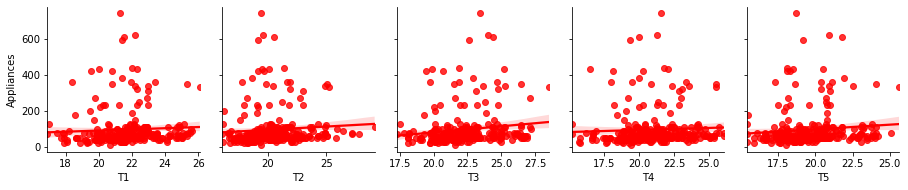

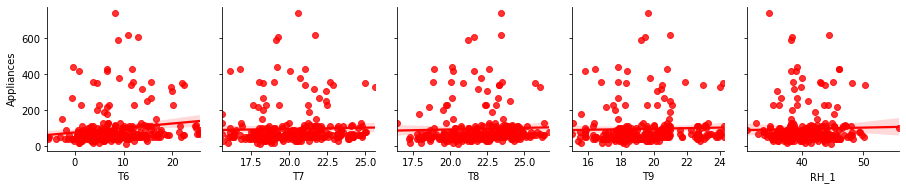

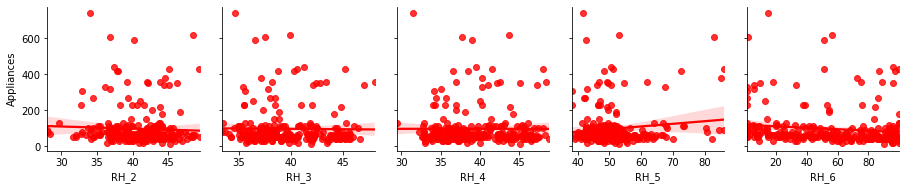

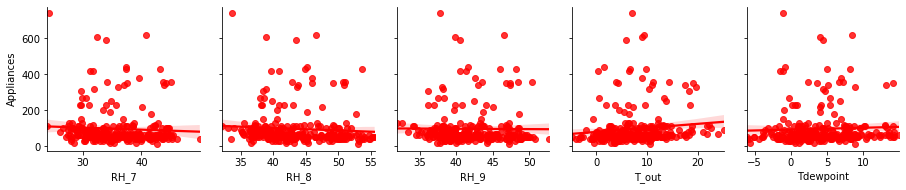

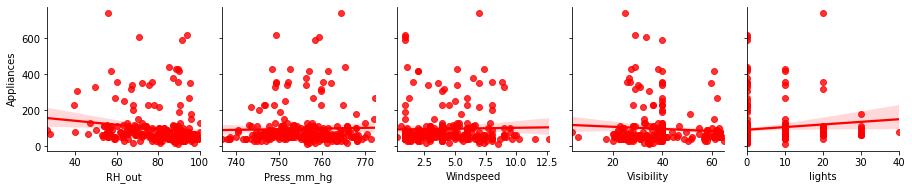

In [17]:
for i in range(5):
    g = sns.PairGrid(train[:2*day],
                 x_vars=col_vars[i*5:(i+1)*5],
                 y_vars=[col_target])
    g = g.map(sns.regplot, color='red')

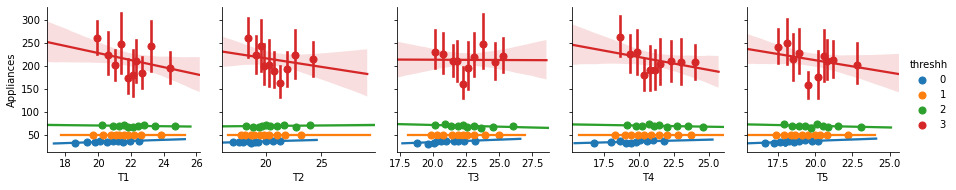

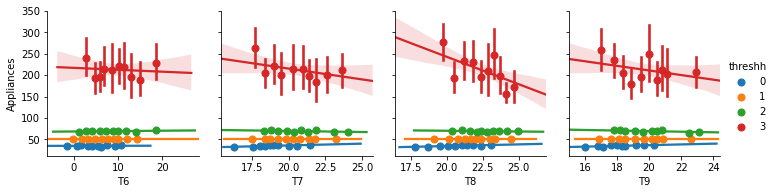

In [18]:
# Indoor temperatures
for i in range(2):
    g = sns.PairGrid(train[:10*day],
                 x_vars=col_temp[i*5:(i+1)*5],
                 y_vars=[col_target], hue="threshh")
    g = g.map(sns.regplot, x_bins=10)
    g.add_legend()

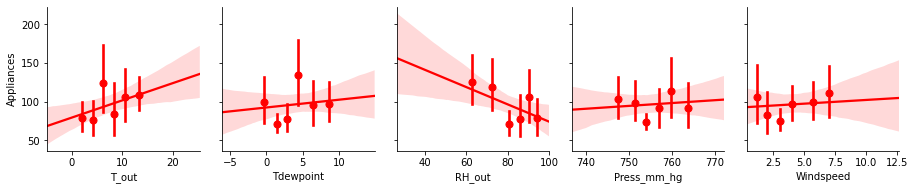

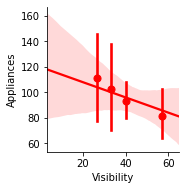

In [19]:
for i in range(2):
    g = sns.PairGrid(train[:2*day],
                 x_vars=col_weather[i*5:(i+1)*5],
                 y_vars=[col_target])
    g = g.map(sns.regplot, color='red', x_bins=6)

# Preprocessing LassoReg

# Preprocessing kNN

In [ ]:
from sklearn.impute import SimpleImputer

df_knn = df_raw

from sklearn.impute import SimpleImputer

imputerQ1 = SimpleImputer(missing_values='?', strategy='constant', fill_value=0.3)
imputerQ1 = imputerQ1.fit(df_knn[['OOBP', 'OSLG']])
df_knn[['OOBP', 'OSLG']] = imputerQ1.transform(df_knn[['OOBP', 'OSLG']])

imputerQ2 = SimpleImputer(missing_values='?', strategy='constant', fill_value=6)
imputerQ2 = imputerQ2.fit(df_knn[['RankSeason']])
df_knn[['RankSeason']] = imputerQ2.transform(df_knn[['RankSeason']])
df_knn.League.replace(['NL', 'AL'], [1, 0], inplace=True)

#Drop useless columns - of no interest
df_knn.drop(['RankPlayoffs', 'Team', 'Year'], axis=1, inplace=True)


In [ ]:
display(df_knn)

# Split into (x,y)

In [22]:
cols_to_drop_for_x = [col_target, 'date', 'lights', 'threshh']+col_randoms

In [23]:
X_train = train.drop(cols_to_drop_for_x, axis=1)
y_train = train[col_target]
display(X_train)
display(y_train)

,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
2133,19.890000,45.50,19.200000,45.090000,20.390000,44.290000,19.10,46.700000,17.511111,53.000000,...,18.111111,50.000000,17.166667,48.700000,10.300000,761.900000,85.500000,7.500000,23.500000,7.950000
19730,25.566667,46.56,25.890000,42.025714,27.200000,41.163333,24.70,45.590000,23.200000,52.400000,...,24.700000,50.074000,23.200000,46.790000,22.733333,755.200000,55.666667,3.333333,23.666667,13.333333
3288,22.500000,44.43,21.533333,42.590000,21.963333,44.555000,22.00,40.466667,19.100000,55.326667,...,20.566667,41.331111,18.600000,45.530000,6.600000,760.200000,64.000000,8.000000,40.000000,0.200000
7730,19.790000,38.06,17.200000,40.933333,20.600000,37.163333,18.39,37.000000,18.290000,42.260000,...,20.500000,42.590000,18.390000,40.723333,2.100000,741.533333,94.333333,1.000000,48.666667,1.233333
8852,20.600000,35.29,17.100000,39.790000,20.290000,37.000000,19.50,34.500000,18.200000,49.000000,...,22.700000,39.260000,18.926667,40.090000,-0.866667,768.266667,92.333333,1.666667,34.000000,-1.933333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,21.760000,40.90,19.390000,43.090000,23.000000,39.000000,21.50,39.790000,20.100000,46.500000,...,24.166667,45.466667,20.356667,40.560000,9.566667,750.466667,77.666667,6.666667,40.000000,5.833333
11964,22.390000,43.70,22.000000,42.066667,22.700000,41.230000,21.29,44.120000,19.700000,48.790000,...,24.200000,47.000000,20.290000,44.290000,17.300000,749.500000,66.000000,2.000000,40.000000,10.900000
5390,20.290000,35.70,18.200000,37.590000,20.100000,37.590000,18.20,35.290000,18.500000,40.572000,...,21.260000,41.700000,17.890000,39.466667,-1.066667,754.900000,87.000000,3.666667,62.666667,-2.933333
860,21.790000,35.56,20.434000,35.116000,21.200000,36.900000,21.10,35.663333,18.050000,46.145000,...,22.700000,39.475000,18.500000,41.466667,2.066667,765.033333,64.333333,1.333333,40.000000,-4.066667


2133      50
19730    100
3288      70
7730      40
8852      40
        ... 
11284     60
11964    120
5390      30
860       80
15795    130
Name: Appliances, Length: 15788, dtype: int64

In [24]:
X_test = test.drop(cols_to_drop_for_x, axis=1)
y_test = test[col_target]
display(X_test, y_test)

,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
8980,20.890000,35.400000,17.760000,39.163333,20.290000,36.900000,19.760000,34.200000,18.600000,51.290000,...,23.068750,39.747500,19.29,39.030000,1.766667,768.900000,88.333333,2.333333,63.000000,0.000000
2754,21.890000,53.100000,21.290000,45.360000,21.633333,49.226667,20.533333,40.966667,17.677778,58.204444,...,20.616667,47.563333,16.29,44.200000,2.700000,754.600000,90.000000,3.000000,27.000000,1.200000
9132,21.390000,35.500000,17.633333,40.530000,21.666667,35.200000,20.290000,33.760000,19.600000,40.290000,...,22.100000,39.626667,19.39,38.290000,0.200000,766.200000,83.000000,2.000000,65.000000,-2.400000
14359,21.390000,41.033333,23.890000,34.840000,22.033333,36.933333,22.390000,35.236000,19.633333,43.266667,...,21.200000,38.090000,20.29,38.560000,8.850000,767.800000,70.833333,5.166667,40.000000,3.716667
8875,19.963333,35.126667,16.463333,40.126667,20.000000,36.400000,19.260000,34.966667,17.890000,49.000000,...,22.100000,39.590000,19.00,40.700000,-0.466667,769.650000,93.333333,4.000000,48.833333,-1.450000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9815,22.290000,36.200000,20.100000,38.066667,22.200000,35.000000,21.200000,33.433333,18.600000,43.790000,...,22.890000,35.590000,19.20,34.500000,5.933333,762.533333,78.166667,2.833333,21.666667,2.366667
9925,22.290000,36.060000,20.890000,36.663333,22.600000,35.760000,19.926667,36.330000,18.856667,46.790000,...,23.390000,37.260000,19.50,39.133333,7.116667,761.050000,71.500000,4.000000,40.000000,2.300000
14088,21.890000,36.463333,23.133333,31.963333,22.390000,35.966667,22.827500,34.131250,20.133333,41.433333,...,21.600000,35.500000,20.70,37.163333,11.300000,761.900000,45.000000,4.000000,40.000000,-0.200000
17356,24.600000,47.530000,22.764286,49.764286,26.700000,43.300000,24.890000,45.400000,23.890000,56.060000,...,25.890000,50.966667,24.10,47.238571,14.666667,748.433333,94.666667,2.333333,22.666667,13.833333


8980      40
2754      90
9132      50
14359     50
8875      70
        ... 
9815      80
9925     100
14088     60
17356     70
17547     50
Name: Appliances, Length: 3947, dtype: int64

<a id='train'></a>

# 2) Model training
---

<a id='linear'></a>

# a) Linear Regression

In [ ]:
Y = df_lin[['W']]
X = df_lin[['RS','RA','OBP','SLG','BA']]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 0)

In [ ]:
linreg = LinearRegression(normalize = True)
linreg.fit(X_train,Y_train)

In [ ]:
linreg.coef_
score = linreg.score(X_test,Y_test)
print("score: ",score)
Y_lin_pred = linreg.predict(X_train)

<a id='lasso'></a>

# b) Lasso Regression

In [ ]:
lasso = Lasso(normalize = True)
parameters = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,2,5,10,20,30,35,40,45,50,55,100]}
lasso_regressor = GridSearchCV(lasso,parameters,scoring = 'neg_mean_squared_error',cv = 5)

In [ ]:
lasso_regressor.fit(X_train,Y_train)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

<a id='knn'></a>

In [ ]:
Y_lasso_pred = lasso_regressor.predict(X_test)

# c) kNN

In [ ]:
train_knn, test_knn = train_test_split(df_knn, test_size=0.3)

x_train_knn = train_knn.drop('W', axis=1)
y_train_knn = train_knn['W']

x_test_knn = test_knn.drop('W', axis=1)
y_test_knn = test_knn['W']


In [ ]:
#Scaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

x_train_knn_scaled = scaler.fit_transform(x_train_knn)
x_train_knn = pd.DataFrame(x_train_knn_scaled)

x_test_knn_scaled = scaler.fit_transform(x_test_knn)
x_test_knn = pd.DataFrame(x_test_knn_scaled)

In [ ]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error
from math import sqrt

<a id='rf'></a>

In [ ]:
rmse_val_knn = [] # to store rmse values for different k
for k in range(15):
    k = k + 1
    model = neighbors.KNeighborsRegressor(n_neighbors=k)
    model.fit(x_train_knn, y_train_knn)
    pred = model.predict(x_test_knn)
    error = sqrt(mean_squared_error(y_test_knn, pred))
    rmse_val_knn.append(error)
    print("RMSE for k={}: {}".format(k, error))
    print("R^2 for k={}: {}\n".format(k, model.score(x_test_knn, y_test_knn)))

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(range(1,26), rmse_val_knn, color='blue', linestyle='dashed', marker='o',
        markerfacecolor='red', markersize=5)
plt.title('RMSE vs. k-Value')
plt.xlabel('k')
plt.ylabel('RMSE')

## Optimizing kNN-search for optimal k-Value via Gridsearch

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors': range(1, 25)}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=100)
model.fit(x_train_knn, y_train_knn)
print("Best k-Value is: ", model.best_params_['n_neighbors'])

In [ ]:
model_cv = neighbors.KNeighborsRegressor(n_neighbors=model.best_params_['n_neighbors'])
model_cv.fit(x_train_knn, y_train_knn)
pred_cv = model.predict(x_test_knn)
sns.distplot(y_test_knn)
sns.distplot(pred_cv, color='red')


# d) Random Forest

In [25]:
import math
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m, X_train, X_valid, y_train, y_valid, score=''):
    res = {
        'RMS(train)': rmse(m.predict(X_train), y_train),
        'RMS(valid)': rmse(m.predict(X_valid), y_valid)}
    if score=='neg_mean_squared_error':
        res['Model_Score=r²'] = [np.sqrt(-m.score(X_train, y_train)), np.sqrt(-m.score(X_valid, y_valid))]
    elif score=='pos_mean_squared_error':
        res['Model_Score=r²'] = [np.sqrt(m.score(X_train, y_train)), np.sqrt(m.score(X_valid, y_valid))]
    else:
        res['Model_Score=r²'] = [m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res['oob_score_'] = m.oob_score_
    display(res)
    return res

# Feature importance
from prettytable import PrettyTable as PT # pip install PTable
def print_RF_featureImportance(rf, X):
    table = PT()
    table.field_names = ['Feature', 'Score', 'Comment']
    sum = 0
    for name, score in zip(X.columns.values, rf.feature_importances_):
        print(f"{name}: {score:.5f}\t\t... {col_dict[name]}")
        table.add_row([name, round(score, ndigits=4), col_dict[name]])
        sum += score
    print(table)
    print(f"sum = {sum}")

def print_GridSearchResult(grid):
    print(grid.best_params_)
    print(grid.best_estimator_)

In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15788 entries, 2133 to 15795
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   T1           15788 non-null  float64
 1   RH_1         15788 non-null  float64
 2   T2           15788 non-null  float64
 3   RH_2         15788 non-null  float64
 4   T3           15788 non-null  float64
 5   RH_3         15788 non-null  float64
 6   T4           15788 non-null  float64
 7   RH_4         15788 non-null  float64
 8   T5           15788 non-null  float64
 9   RH_5         15788 non-null  float64
 10  T6           15788 non-null  float64
 11  RH_6         15788 non-null  float64
 12  T7           15788 non-null  float64
 13  RH_7         15788 non-null  float64
 14  T8           15788 non-null  float64
 15  RH_8         15788 non-null  float64
 16  T9           15788 non-null  float64
 17  RH_9         15788 non-null  float64
 18  T_out        15788 non-null  float64
 19  P

In [27]:
before = 0

In [28]:
from numpy import sqrt
num_features = X_train.shape[1]
print(num_features)
sqrt_num_features = int(round(sqrt(num_features), 0))
sqrt_num_features

24


5

In [37]:
# Simple training of RFRegressor
n_cores = 4
rf = RandomForestRegressor(n_jobs=n_cores, n_estimators=500, max_features=0.5, min_samples_leaf=1, oob_score=True, verbose=1)
# The following code is supposed to fail due to string values in the input data
rf.fit(X_train, y_train)
print("Before:")
display(before)#
print("Now:")
before = print_score(rf, X_train, X_test, y_train, y_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   17.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   19.4s finished


Before:


{'RMS(train)': 35.1220623116172,
 'RMS(valid)': 64.06714653458683,
 'Model_Score=r²': [0.8840250494775422, 0.589830928238515],
 'oob_score_': 0.5683860006207266}

Now:


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.5s finished
[

{'RMS(train)': 24.116372742997637,
 'RMS(valid)': 62.075335931722755,
 'Model_Score=r²': [0.9453200444066345, 0.6149383177572401],
 'oob_score_': 0.5935269640499681}

In [ ]:
rf

In [ ]:
print_RF_featureImportance(rf, X_train)

In [ ]:
rf_prediction = rf.predict(X_train)
sns.distplot(y_train-rf_prediction)

In [ ]:
rf_prediction = rf.predict(X_test)
sns.distplot(y_test-rf_prediction)

In [ ]:
n_cores = 4
number_of_trees = 1000 # default = 100
rf = RandomForestRegressor(n_jobs=n_cores, n_estimators=number_of_trees, bootstrap=True) #, verbose=1)

rf.fit(X_train, y_train)
print("Before:")
display(before)#
print("Now:")
before = print_score(rf, X_train, X_test, y_train, y_test)
print()
print("Feature importance")
print_RF_featureImportance(rf, X_train)
rf_RD = rf

In [ ]:
rfRD_prediction = rf_RD.predict(X_test)

In [ ]:
sns.distplot(y_test-rfRD_prediction)

In [ ]:
from sklearn.model_selection import GridSearchCV
n_cores = 4
# but since we dont have that many features...we are just gonna brute force it :D
param_grid = [
    {
        'n_estimators': [3, 10, 30, 100, 1000], 'max_features': [i for i in range(1,num_features+1)]
    }
#,{'bootstrap': [False], 'n_estimators': [3, 30, 100, 1000], 'max_features': [2, 3, 4]},
]
k = 10
forest_reg = RandomForestRegressor(n_jobs=n_cores)
grid_search = GridSearchCV(forest_reg, param_grid, n_jobs=n_cores , cv=k, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)


In [ ]:
print_GridSearchResult(grid_search)
grid_search.scorer_()
scores = grid_search.score(X_test, y_test)
print_score(grid_search, X_train, X_test, y_train, y_test)

# k-fold cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
from prettytable import PrettyTable

def display_scores(scores):
    print("Scores:", scores)
    table = PrettyTable()
    table.field_names = ['Run', 'Score']
    for i, score in enumerate(scores):
        table.add_row([i, round(score, 3)])
    print(table)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [ ]:
k = 5
model = rf_RD
scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=k)

In [ ]:
display_scores(rf_rmse_scores)

<a id='eval'></a>

# 3) Evaluation

# a) Linear Regression

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_train, Y_lin_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_train, Y_lin_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_train, Y_lin_pred)))

In [ ]:
sns.distplot(Y_train)
sns.distplot(Y_lin_pred)

# b) Lasso Regression

In [ ]:
sns.distplot(Y_train)
sns.distplot(Y_lasso_pred)

In [ ]:
# geht leider noch nicht die dimesionen passen nicht zusammen
#print('Mean Absolute Error:', metrics.mean_absolute_error(Y_train, Y_lasso_pred))  
#print('Mean Squared Error:', metrics.mean_squared_error(Y_train, Y_lasso_pred))  
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_train, Y_lasso_pred)))

# c) k-Nearest Neighbors

# Save model and DF

In [ ]:
# Dump model
import joblib
import os

os.makedirs('tmp', exist_ok=True)
joblib.dump(rf_RD, "tmp/rf_RD.pkl")
# To load the model
# my_model_loaded = joblib.load("my_model.pkl")

In [ ]:
import os
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')
df_raw = pd.read_feather('tmp/raw')